In [46]:
try:
    import librosa
except:
    !pip install librosa
    !pip install matplotlib

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Plotting Waveform of a track

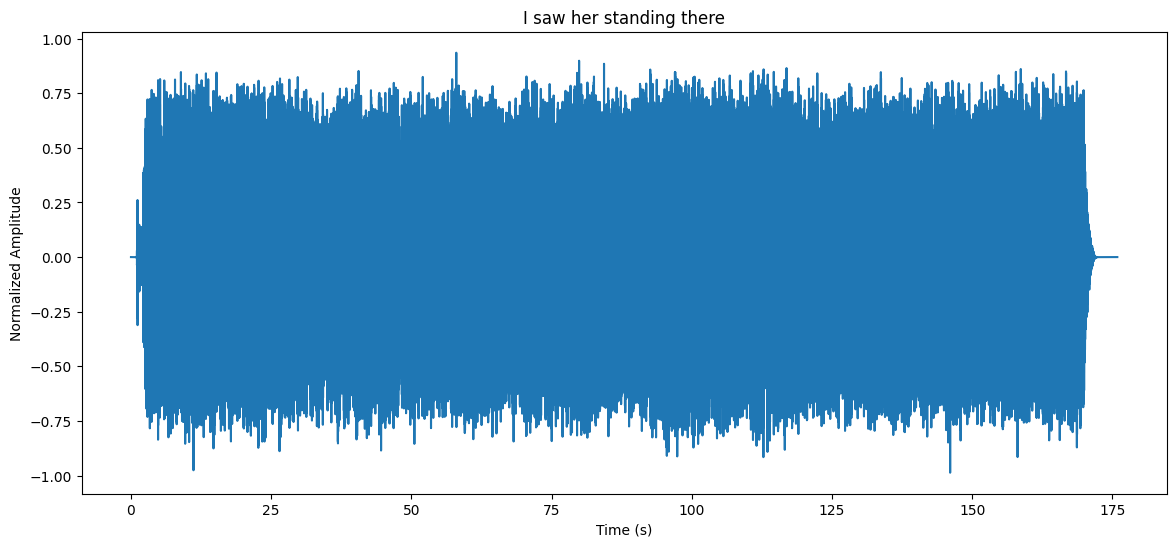

In [52]:
audio_file = "/home/aitha/thanos/audio/TheBeatles/01_-_Please_Please_Me/01_-_I_Saw_Her_Standing_There.wav"
y, sr = librosa.load(audio_file, sr=44100, mono=True)
# fig, ax = librosa.display.waveshow(y, sr=sr)

# get timestamps via sampling rate
times = [sample/sr for sample in range(len(y))]

plt.figure(figsize=(14,6))
plt.plot(times, y)
plt.title("I saw her standing there")

plt.ylabel('Normalized Amplitude')
plt.xlabel('Time (s)')
plt.show()

# Fourier transforms

In [63]:
def get_mfcc(data, sr, n_mfcc):
    '''Gets mfccs given a array like data structure and its sampling rates
    '''
    mfccs = []

    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc).T
        
    return mfcc

In [65]:
mfcc = get_mfcc(y, sr, 13)
# max_length = len(max(mfccs, key=len))

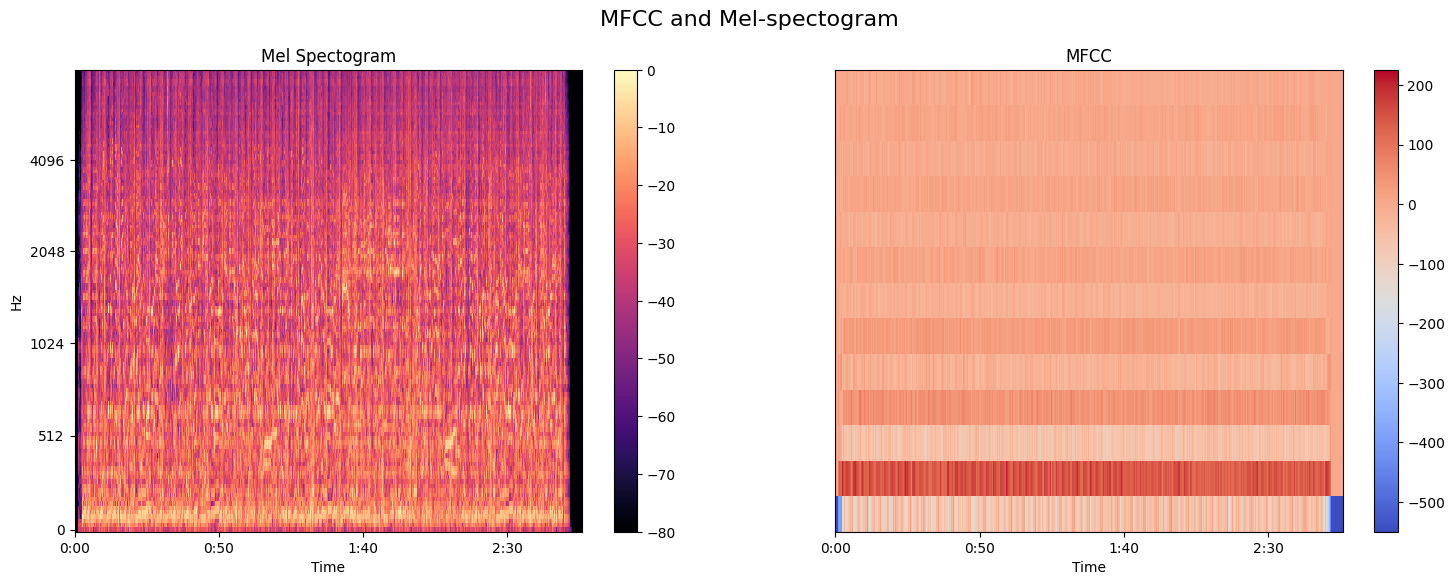

In [75]:
fig, ax = plt.subplots(1,2, figsize=(18,6), sharex=True)
    
# Get mel-spectogram as well
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                               fmax=8000)

# Plot mel - spectogram
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr,
                           x_axis='time', y_axis='mel', fmax=8000,
                           ax=ax[0])
ax[0].set(title = "Mel Spectogram")
fig.colorbar(img, ax=ax[0])

# Plot MFCC
img = librosa.display.specshow(mfcc.T, x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title = 'MFCC')

fig.colorbar(img, ax=ax[1])

fig.suptitle('MFCC and Mel-spectogram', fontsize=16)
plt.show()